# Исследование надёжности заёмщиков

##### Проведение исследования зависимости риска возникновения задолженности от различных факторов.

##### Цель исследования.

Нужно разобраться, влияет ли семейное положение, количество детей клиента и цели займа на факт погашения кредита в срок.

##### Задачи исследования.

Результаты исследования будут учтены при построении модели **кредитного скоринга** — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

##### Исходные данные.

Входные данные от банка — статистика о платёжеспособности клиентов:

    children — количество детей в семье
    days_employed — общий трудовой стаж в днях
    dob_years — возраст клиента в годах
    education — уровень образования клиента
    education_id — идентификатор уровня образования
    family_status — семейное положение
    family_status_id — идентификатор семейного положения
    gender — пол клиента
    income_type — тип занятости
    debt — имел ли задолженность по возврату кредитов
    total_income — ежемесячный доход
    purpose — цель получения кредита

##### План исследования.

[Часть 1. Изучение данных:](#step1)

[Часть 2. Предобработка данных:](#step2)

   * [Обработка аномальных значений](#step21)
   * [Обработка пропусков](#step22)
   * [Замена типа данных](#step23)
   * [Обработка дубликатов](#step24)
   * [Лемматизация](#step25)
   * [Категоризация данных](#step26)
   
[Часть 3. Ответы на поставленные вопросы](#step3)


[Часть 4. Общий вывод](#step4)

### Часть 1. Изучение данных <a id="step1"></a>
Импортируем библиотеки

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import pymorphy2
import os
from collections import Counter

Откроем таблицу и изучим данные первых 10 строк.

In [4]:
if os.path.exists('data.csv'): # проверка валидности пути к датасету при работе локально и с портала
    df = pd.read_csv('data.csv')
else:
    df = pd.read_csv('/datasets/data.csv')

df_initial = df.copy() # создаём копию исходного датасета для сверки с изменённым вариантом

df.head(10)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
5,0,-926.185831,27,высшее,0,гражданский брак,1,M,компаньон,0,255763.565419,покупка жилья
6,0,-2879.202052,43,высшее,0,женат / замужем,0,F,компаньон,0,240525.971920,операции с жильем
7,0,-152.779569,50,СРЕДНЕЕ,1,женат / замужем,0,M,сотрудник,0,135823.934197,образование
8,2,-6929.865299,35,ВЫСШЕЕ,0,гражданский брак,1,F,сотрудник,0,95856.832424,на проведение свадьбы
9,0,-2188.756445,41,среднее,1,женат / замужем,0,M,сотрудник,0,144425.938277,покупка жилья для семьи


Изучим общие данные о таблице.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


А также статистическую информацию.

In [6]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
children,21525.0,0.538908,1.381587,-1.000000,0.000000,0.000000,1.000000,2.000000e+01
days_employed,19351.0,63046.497661,140827.311974,-18388.949901,-2747.423625,-1203.369529,-291.095954,4.017554e+05
dob_years,21525.0,43.293380,12.574584,0.000000,33.000000,42.000000,53.000000,7.500000e+01
education_id,21525.0,0.817236,0.548138,0.000000,1.000000,1.000000,1.000000,4.000000e+00
family_status_id,21525.0,0.972544,1.420324,0.000000,0.000000,0.000000,1.000000,4.000000e+00
debt,21525.0,0.080883,0.272661,0.000000,0.000000,0.000000,0.000000,1.000000e+00
total_income,19351.0,167422.302208,102971.566448,20667.263793,103053.152913,145017.937533,203435.067663,2.265604e+06


Проверим уникальные значения по некоторым столбцам. Проверку по столбцам без проблемных значений опустим.

In [7]:
df['gender'].unique()

array(['F', 'M', 'XNA'], dtype=object)

Проверим частоту с которой встречается уникальное значение `XNA`

In [8]:
df[df['gender'] == 'XNA']

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
10701,0,-2358.600502,24,неоконченное высшее,2,гражданский брак,1,XNA,компаньон,0,203905.157261,покупка недвижимости


Значение встречается один раз. По косвенным признакам определить пол невозможно. Т.к. значение одно на 21525, на результаты сильно не повлияет, оставим как есть.

**Выводы**

В названиях столбцов ошибок нет.

В столбце `children` есть отрицательные значения и двузначные, предположительно ошибка ввода

В столбце `days_employed` данные представлены с ошибками и пропусками, требуют обработки.
* Пердпочтительный формат для подсчёта количества дней - целочисленный.
* Отрицательные числа для подсчёта дней не имеют смысла, вероятно, тут ошибка в знаке.
* Некоторые данные явно ошибочны. Пример: пенсионерка из 4ой ячейки, её стаж составляет 932 года.

В столбце `education` присутствуют значения в разном регистре, следует привести их к единому виду.

В столбце `total_income` значения представлены в формате **float**, можно заменить его на **int32** для экономии памяти, также отсутствует часть данных, необходима обработка.

## Часть 2. Предобработка данных <a id="step2"></a>

### Обработка аномальных значений <a id="step21"></a>

Перед заполнением пропусков необходимо скорректировать знак в столбце `days_employed`.

In [9]:
df['days_employed'] = abs(df['days_employed'])

В столбце `children` заменим отрицательные значения на положительные и на порядок понизим значение `20`.

In [10]:
df['children'] = abs(df['children'])
df['children'] = df['children'].transform(lambda x: x/10 if x == 20 else x)

Теперь проверим распределение данных о стаже по возрасту.

<AxesSubplot:xlabel='dob_years', ylabel='days_employed'>

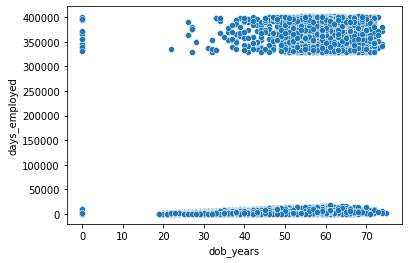

In [11]:
sns.scatterplot(x="dob_years", y="days_employed", data=df)

Виден аномальный выброс данных по стажу. Найдём количество строк с нулевыми значениями возраста, а также количество строк с аномальными данными.

In [12]:
df[df['dob_years'] == 0].shape[0]

101

In [13]:
df[df['days_employed'] > 15000].shape[0]

3458

Количество пропусков по возрасту небольшое и на результаты исследования значительного влияния не окажет. Заменим эти данные минимальным трудоспособным возрастом.

Аномальные значения стажа заменим на максимальный стаж для данного возраста. Это повлияет на результаты, но достать исправные даные у нас нет возможности. Ещё один вариант который можно было бы опробовать - выделить все аномальные данные во второй набор, проанализировать отдельно и сравнить результаты.

In [14]:
def minimum_years(row):
    '''
    Функция проверяет возраст и если он равен нулю, возвращает 19, иначе оставляет без изменений.
    '''
    if row['dob_years'] == 0:
        return 19
    else:
        return row['dob_years']

df['dob_years'] = df.apply(minimum_years, axis=1)

In [15]:
def max_days(row):
    '''
    Функция проверяет количество дней трудоустройства и возвращает
    максимальное количество дней для данного возраста и пола
    если ранее в ячейке стояло аномально большое число или 0.
    '''
    if (row['gender'] == 'M' and row['dob_years'] < 65
        and row['days_employed'] > ((row['dob_years'] - 16) * 365) or row['days_employed'] == 0):
        return (row['dob_years'] - 16) * 365
    elif (row['gender'] == 'F' and row['dob_years'] < 60
          and row['days_employed'] > ((row['dob_years'] - 16) * 365) or row['days_employed'] == 0):
        return (row['dob_years'] - 16) * 365
    elif row['gender'] == 'M' and row['dob_years'] >= 65:
        return (65 - 16) * 365
    elif row['gender'] == 'F' and row['dob_years'] >= 60:
        return (60 - 16) * 365
    else:
        return row['days_employed']

df['days_employed'] = df.apply(max_days, axis=1)

Повторно проверим распределение данных о стаже по возрасту.

<AxesSubplot:xlabel='dob_years', ylabel='days_employed'>

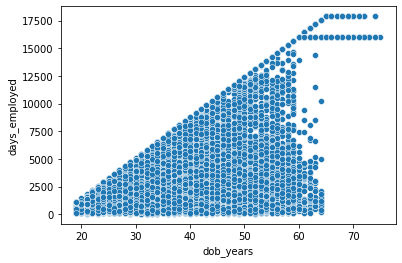

In [16]:
sns.scatterplot(x="dob_years", y="days_employed", data=df)

**Вывод**

* В столбце `children` исправили отрицательные значения и двузначные.
* В столбце `days_employed` исправили знак чисел, нулевые значения и аномальные данные.

Мы очистили данные от явно неверных и отрицательных значений. Теперь можно перейти к обработке пропусков.




### Обработка пропусков <a id="step22"></a>
Сначала проверим общее количество пропусков в данных.

In [17]:
df_initial.isna().sum()

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64

По 2174 пропущенных значения в столбцах `days_employed` и `total_income`, проверим одновременность появления пропадающих значений.

In [18]:
def sim_check(row):
    '''
    Функция проверяет одновременность появления пропущенных значений в столбцах 'days_employed' и 'total_income'.
    '''
    if pd.isna(row['days_employed']) and ~(pd.isna(row['total_income'])):
        return 1
    else:
        return 0
        
if df.apply(sim_check, axis=1).sum() == 0:
    print('Пропущенные значения появляются одновременно.')
else:
    print('Пропущенные значения появляются не одновременно.')

Пропущенные значения появляются не одновременно.


Вероятно, произошёл технический сбой при выгрузке в таблицу части данных. Объём пропущенных значений - больше 10% от общего количества, что значительно повлияет на результаты исследования. Восстановить данные не представляется возможным, поэтому необходимо будет заполнить пропущенные значения.

Для заполнения пропущенных данных о стаже возьмём медианное значение внутри разных возрастных групп, т.к. чаще всего стаж напрямую коррелирует с возрастом.

Данные о доходе возьмём как медиану от заработка внутри групп по типу занятости.

Заполним пропущенные данные в столбце `days_employed`, сгруппировав по столбцу `dob_years`

In [19]:
df['days_employed'] = df.groupby('dob_years')['days_employed'].transform(lambda x: x.fillna(x.median()))

Заполним пропущенные данные в столбце `total_income`, сгруппировав по столбцу `income_type`

In [20]:
df['total_income'] = df.groupby('income_type')['total_income'].transform(lambda x: x.fillna(x.median()))

Снова проверим общее количество пропусков в данных.

In [21]:
df.isna().sum()

children            0
days_employed       0
dob_years           0
education           0
education_id        0
family_status       0
family_status_id    0
gender              0
income_type         0
debt                0
total_income        0
purpose             0
dtype: int64

**Вывод**

Мы очистили данные от пропусков:
* для столбца `days_employed` заполнив данные медианой для соответствующих возрастных груп;
* для столбцы `total_income` заполнив данные медианой для соответствующих групп по типу заработка.

Теперь можно перейти к замене неподходящих типов данных.

### Замена типа данных <a id="step23"></a>

Сначала ещё раз посмотрим на информацию по табличным данным.

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  float64
 1   days_employed     21525 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      21525 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(3), int64(4), object(5)
memory usage: 2.0+ MB


Проверим диапазоны значений в столбцах после замены аномальных данных и пропусков.

In [23]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
children,21525.0,0.479721,0.755528,0.000000,0.000000,0.000000,1.000000,5.000000e+00
days_employed,21525.0,4828.407434,5561.686353,24.141633,1017.805320,2203.078545,5920.998376,1.788500e+04
dob_years,21525.0,43.382532,12.332333,19.000000,33.000000,42.000000,53.000000,7.500000e+01
education_id,21525.0,0.817236,0.548138,0.000000,1.000000,1.000000,1.000000,4.000000e+00
family_status_id,21525.0,0.972544,1.420324,0.000000,0.000000,0.000000,1.000000,4.000000e+00
debt,21525.0,0.080883,0.272661,0.000000,0.000000,0.000000,0.000000,1.000000e+00
total_income,21525.0,165225.324514,98043.665491,20667.263793,107798.172619,142594.396847,195549.940861,2.265604e+06


Данные в столбцах `children`, `dob_years`, `education_id`, `family_status_id`, `debt` можно заменить на тип `int8`.

В столбце `days_employed` заменить на `int16`.

Столбец `total_income` лучше оставить в типе `int64`.


In [24]:
df = df.astype({'children':'int8', 'dob_years':'int8', 'education_id':'int8',
                'family_status_id':'int8', 'debt':'int8', 'days_employed':'int16', 'total_income':'int64'})

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   children          21525 non-null  int8  
 1   days_employed     21525 non-null  int16 
 2   dob_years         21525 non-null  int8  
 3   education         21525 non-null  object
 4   education_id      21525 non-null  int8  
 5   family_status     21525 non-null  object
 6   family_status_id  21525 non-null  int8  
 7   gender            21525 non-null  object
 8   income_type       21525 non-null  object
 9   debt              21525 non-null  int8  
 10  total_income      21525 non-null  int64 
 11  purpose           21525 non-null  object
dtypes: int16(1), int64(1), int8(5), object(5)
memory usage: 1.1+ MB


**Вывод**

Мы заменили типы данных на более подходящие, исходя из анализа диапазона возможных значений. Как текущих, так и возможных при обновлении данных.

Рациональная замена типов данных позволила нам уменьшить объём используемой памяти с 2.0 до 1.1. МБ, т.е. на 55%.

### Обработка дубликатов <a id="step24"></a>

При просмотре данных таблицы мы заметили что в категориальных данных есть неявные дубликаты связанные с ошибками ввода (разный регистр). Проверим столбцы с данными и исправим неверные значения переводом в единый регистр.

In [26]:
df['education'].unique()

array(['высшее', 'среднее', 'Среднее', 'СРЕДНЕЕ', 'ВЫСШЕЕ',
       'неоконченное высшее', 'начальное', 'Высшее',
       'НЕОКОНЧЕННОЕ ВЫСШЕЕ', 'Неоконченное высшее', 'НАЧАЛЬНОЕ',
       'Начальное', 'Ученая степень', 'УЧЕНАЯ СТЕПЕНЬ', 'ученая степень'],
      dtype=object)

Применим метод `.str.lower()` библиотеки `Pandas`

In [27]:
df['education'] = df['education'].str.lower()
df['education'].unique()

array(['высшее', 'среднее', 'неоконченное высшее', 'начальное',
       'ученая степень'], dtype=object)

Проведём аналогичную проверку и исправление для других категориальных строковых данных.

In [28]:
df['family_status'].unique()

array(['женат / замужем', 'гражданский брак', 'вдовец / вдова',
       'в разводе', 'Не женат / не замужем'], dtype=object)

In [29]:
df['family_status'] = df['family_status'].str.lower()
df['family_status'].unique()

array(['женат / замужем', 'гражданский брак', 'вдовец / вдова',
       'в разводе', 'не женат / не замужем'], dtype=object)

Проведём проверку столбца описывающего категорию дохода.

In [30]:
df['income_type'].unique()

array(['сотрудник', 'пенсионер', 'компаньон', 'госслужащий',
       'безработный', 'предприниматель', 'студент', 'в декрете'],
      dtype=object)

В данном столбце проблем нет.

In [31]:
df['purpose'].unique()

array(['покупка жилья', 'приобретение автомобиля',
       'дополнительное образование', 'сыграть свадьбу',
       'операции с жильем', 'образование', 'на проведение свадьбы',
       'покупка жилья для семьи', 'покупка недвижимости',
       'покупка коммерческой недвижимости', 'покупка жилой недвижимости',
       'строительство собственной недвижимости', 'недвижимость',
       'строительство недвижимости', 'на покупку подержанного автомобиля',
       'на покупку своего автомобиля',
       'операции с коммерческой недвижимостью',
       'строительство жилой недвижимости', 'жилье',
       'операции со своей недвижимостью', 'автомобили',
       'заняться образованием', 'сделка с подержанным автомобилем',
       'получение образования', 'автомобиль', 'свадьба',
       'получение дополнительного образования', 'покупка своего жилья',
       'операции с недвижимостью', 'получение высшего образования',
       'свой автомобиль', 'сделка с автомобилем',
       'профильное образование', 'высшее об

В столбце с целями весь текст в одном регистре. Есть похожие по смыслу но разные по формулировке цели, мы их  рассмотрим позже при категоризации.

Теперь проверим наличие дубликатов.

In [32]:
df.duplicated().sum()

71

Применим метод `drop_duplicates()` в сочетании с методом `reset_index(drop = True)` для сброса индексов таблицы без повторов.

In [33]:
df = df.drop_duplicates().reset_index(drop = True)

Проверим снова общее количество дубликатов.

In [34]:
df.duplicated().sum()

0

**Вывод**

Мы избавились от явных и скрытых дубликатов, можно переходить к анализу содержимого колонки `purpose`.

### Лемматизация <a id="step25"></a>

Используя библиотеку `pymorphy2` (`pymystem3` не работает под Windows) проведём лемматизацию, используя функцию  лемматизации и метод `.transform()`. Результаты сохраним в новом столбце `purpose_lemmas`.

In [35]:
morph = pymorphy2.MorphAnalyzer()

lemmas_list = [] # создадим общий список лемм для дальнейшего отбора категорий

def lemmas(text):
    '''
    Функция лемматизирует значения из строки и возвращает список с леммами.
    '''
    words = text.split()
    result = list()
    for word in words:
        lemma = morph.parse(word)[0].normal_form
        result.append(lemma)
        lemmas_list.append(lemma)
    return result

df_lemmas = df.copy()
df_lemmas['purpose_lemmas'] = df_lemmas['purpose'].transform(lemmas)

Для проверки выведем первые и последние 5 строк таблицы.

In [36]:
df_lemmas

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,purpose_lemmas
0,1,8437,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья,"[покупка, жильё]"
1,1,4024,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля,"[приобретение, автомобиль]"
2,0,5623,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885,покупка жилья,"[покупка, жильё]"
3,3,4124,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628,дополнительное образование,"[дополнительный, образование]"
4,0,13505,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу,"[сыграть, свадьба]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21449,1,4529,43,среднее,1,гражданский брак,1,F,компаньон,0,224791,операции с жильем,"[операция, с, жильё]"
21450,0,16060,67,среднее,1,женат / замужем,0,F,пенсионер,0,155999,сделка с автомобилем,"[сделка, с, автомобиль]"
21451,1,2113,38,среднее,1,гражданский брак,1,M,сотрудник,1,89672,недвижимость,[недвижимость]
21452,3,3112,38,среднее,1,женат / замужем,0,M,сотрудник,1,244093,на покупку своего автомобиля,"[на, покупка, свой, автомобиль]"


**Вывод**

Сравнивая столбцы `puprose` и `purpose_lemmas` мы видим что лемматизация прошла успешно и теперь можно приступать к категоризации данных.

### Категоризация данных <a id="step26"></a>

Проверим общий список лемм и выберем наиболее часто встречающиеся.

In [37]:
Counter(lemmas_list).most_common(20)

[('недвижимость', 6351),
 ('покупка', 5897),
 ('жильё', 4460),
 ('автомобиль', 4306),
 ('образование', 4013),
 ('с', 3545),
 ('операция', 2604),
 ('свадьба', 2324),
 ('свой', 2230),
 ('на', 2222),
 ('строительство', 1878),
 ('высокий', 1374),
 ('получение', 1314),
 ('коммерческий', 1311),
 ('для', 1289),
 ('жилой', 1230),
 ('подержать', 964),
 ('сделка', 941),
 ('дополнительный', 906),
 ('заняться', 904)]

Отбросив предлоги и местоимения, а также сравнив с ранее полученным списком уникальных значений, получим список основных целей для взятия кредита:

* ремонт
* жильё (если нет леммы ремонт)
* коммерческий
* недвижимость (если нет леммы коммерческий или жильё)
* автомобиль
* образование
* свадьба

Необходимо заменить ошибочную лемму `жила` на `жильё`

In [38]:
def replacement(lemmas):
    '''
    Функция ищет в списке лемм 'жила' и заменяет на 'жильё'.
    '''
    for i in range(len(lemmas)):
        if lemmas[i] == 'жила':
            lemmas[i] = 'жильё'
    return lemmas    

df_lemmas['purpose_lemmas'] = df_lemmas['purpose_lemmas'].transform(replacement)

Через функцию присвоим каждой строке определённую категорию, опираясь на леммы в столбце `puprose_lemmas`.

In [39]:
def purpose_category(lemmas):
    '''
    Функция проверяет наличие в списке лемм строки наличие выделенных категорий
    и присваивает определённую категорию.
    '''
    if 'ремонт' in lemmas:
        return 'ремонт'
    elif 'жильё' in lemmas:
        return 'жильё'
    elif 'коммерческий' in lemmas:
        return 'коммерческий'
    elif 'недвижимость' in lemmas:
        return 'недвижимость'
    elif 'автомобиль' in lemmas:
        return 'автомобиль'
    elif 'образование' in lemmas:
        return 'образование'
    else:
        return 'свадьба'
    
df['purpose_status'] = df_lemmas['purpose_lemmas'].transform(purpose_category)

Категоризируем заёмщиков по наличию детей:
* бездетные
* с детьми (от одного до двух)
* многодетные (трое и больше)

In [40]:
def children_category(children):
    '''
    Функция проверяет количество детей и присваивает определённую категорию.
    '''
    if children == 0:
        return 'бездетные'
    elif 1 <= children <= 2:
        return 'с детьми'
    else:
        return 'многодетные'
    
df['children_status'] = df['children'].transform(children_category)

Теперь проведём категоризацию уровней дохода. Сначала посмотрим на общее распределение доходов.

In [41]:
df['total_income'].describe().astype('int')

count      21454
mean      165319
std        98187
min        20667
25%       107623
50%       142594
75%       195820
max      2265604
Name: total_income, dtype: int32

Разделим с помощью функции все доходы по персентилю:
* низкий (ниже 25ого персентиля)
* средний (от 25ого до 75 персентиля)
* высокий (выше 75го персентиля)

In [42]:
low_income = df['total_income'].quantile(0.25) # вычисляем персентили вне функции
high_income = df['total_income'].quantile(0.75)

def income_category(income):
    '''
    Функция проверяет совокупный доход и присваивает определённую категорию.
    '''
    if income < low_income:
        return 'низкий'
    elif low_income <= income <= high_income:
        return 'средний'
    else:
        return 'высокий'
    
df['income_status'] = df['total_income'].transform(income_category)

columns_titles = ['children', 'children_status', 'days_employed', 'dob_years', 'education', 'education_id',
                  'family_status', 'family_status_id', 'gender', 'income_type', 'debt',
                  'total_income', 'income_status', 'purpose', 'purpose_status']
df=df.reindex(columns=columns_titles)

Проверим основную таблицу с данными.

In [43]:
df.head(5)

,children,children_status,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,income_status,purpose,purpose_status
0,1,с детьми,8437,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875,высокий,покупка жилья,жильё
1,1,с детьми,4024,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,средний,приобретение автомобиля,автомобиль
2,0,бездетные,5623,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885,средний,покупка жилья,жильё
3,3,многодетные,4124,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628,высокий,дополнительное образование,образование
4,0,бездетные,13505,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616,средний,сыграть свадьбу,свадьба


**Вывод**

Мы провели категоризацию необходимых данных и можем приступить к провере гипотез.

## Часть 3. Ответы на поставленные вопросы <a id="step3"></a>

- Есть ли зависимость между наличием детей и возвратом кредита в срок?

Сгруппируем данные и посчитаем процент задолженностей в зависимости от наличия детей.

In [44]:
def debt_probability(column):
    '''
    Функция подсчитывает вероятность возникновения долга для поданного набора данных после группировки.
    '''
    quantity = 0
    total = 0
    for i in column:
        quantity += 1
        total += i
    return '{:.2%}'.format(total/quantity)

df.pivot_table(index='children_status', values='debt', aggfunc=['sum', 'count', debt_probability])

,sum,count,debt_probability
,debt,debt,debt
children_status,,,
бездетные,1063.0,14091,7.54%
многодетные,31.0,380,8.16%
с детьми,647.0,6983,9.27%


**Вывод**

Зависимость вероятности задолженности от наличия детей есть:

Вероятность возникновения долга у бездетных клиентов ниже на 1,73% чем у клиентов с 1-2 детьми.

При этом разница с многодетными клиентами несущественна - 0,62%, но из-за недостаточной выборки надёжность данной цифры невысокая.

- Есть ли зависимость между семейным положением и возвратом кредита в срок?

In [45]:
df.pivot_table(index='family_status', values='debt', aggfunc=['sum', 'count', debt_probability])

,sum,count,debt_probability
,debt,debt,debt
family_status,,,
в разводе,85.0,1195,7.11%
вдовец / вдова,63.0,959,6.57%
гражданский брак,388.0,4151,9.35%
женат / замужем,931.0,12339,7.55%
не женат / не замужем,274.0,2810,9.75%


**Вывод**

Зависимость вероятности задолженности от семейного положения есть:

Самая низкая вероятность возникновения задолженности у вдовцов/вдов и у людей в разводе.

Самая высокая - у категории не женат/не замужем, а также у людей состоящих в гражданском браке.

Люди состоящие в официальном браке по уровню риска находятся в умеренной зоне.

Если рассмотрим суммарную статистику по признаку наличия партнёра, то получим вероятность риска для заёмщиков с партнёром - 8,00%, а для заёмщиков без партнёра - 8,50%. Это свидетельствует о том что заёмщики с партнёрами более надёжные.

- Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

In [46]:
df.pivot_table(index='income_status', values='debt', aggfunc=['sum', 'count', debt_probability])

,sum,count,debt_probability
,debt,debt,debt
income_status,,,
высокий,383.0,5364,7.14%
низкий,427.0,5364,7.96%
средний,931.0,10726,8.68%


**Вывод**

Зависимость вероятности задолженности от уровня общего дохода есть:

Меньше всего риск у людей с высоким доходом.

Средний риск у людей с низким доходом.

Высокий риск у людей с медианным доходом.

Вероятно, заёмщики со средним доходом более уверены в своей финансовой стабильности и проще относятся к просрочкам (и штрафным санкциям) по кредиту, чем заёмщики с низким доходом. Проще решаются на крупные расходы не связанные с кредитными обязательствами и чаще сталкиваются с просрочками. Заёмщикам же с высокими доходами имеют свободные средства и им проще не допустить просрочку по кредиту.

- Как разные цели кредита влияют на его возврат в срок?

In [47]:
df.pivot_table(index='purpose_status', values='debt', aggfunc=['sum', 'count', debt_probability])

,sum,count,debt_probability
,debt,debt,debt
purpose_status,,,
автомобиль,403.0,4306,9.36%
жильё,273.0,3853,7.09%
коммерческий,99.0,1311,7.55%
недвижимость,375.0,5040,7.44%
образование,370.0,4013,9.22%
ремонт,35.0,607,5.77%
свадьба,186.0,2324,8.00%


**Вывод**

Зависимость вероятности задолженности от цели кредита есть:

Наименьший риск в категории ремонт, всего 5,77%.

У категорий жильё, коммерческий, недвижимость схожий умеренный риск: от 7,12% до 7,55%.

Категория свадьба также обладает умеренным риском возникновения задолженности.

Наибольший риск у категорий образование и автомобиль, более 9%.

## Часть 4. Общий вывод <a id="step4"></a>

Мы провели обработку исходного датасета. Убрали аномальные значения, обработали пропуски, заменили типы данных, заполнили пропуски и удалили дубликаты. Провели лемматизацию целей взятия кредита и категоризацию необходимых данных.

В ходе проверки гипотез мы подтвердили все предположения. Вероятность возникновения задолженностей по кредиту зависит как от количества детей и семейного положения, так и от общего уровня дохода и целей взятия кредита.

Наименьший риск возникновения задолженности у женатых заёмщиков без детей, с высоким уровнем дохода и берущих кредит на покупку жилья.

Наивысший риск у холостых заёмщиков, имеющих детей, со средним уровнем дохода и берущих кредит на образование или покупку автомобиля.